In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import kagglehub
import torch.onnx as onnx
import pickle
import os
from pathlib import Path



In [ ]:
# Making sure onnxrumtime/onnx python packagaes is installed
# These are needed to convert and save the model into onnx format used for inference
!pip install onnxruntime
!pip install onnx
import onnxruntime as ort

In [43]:
# I have few datasets with credit card fraud information and I have uploaded into
# my own space (shahtabkhandakar) in Kaggle Hub and made it public. This is the dataset I'll use for my model.
# The powerpoint slides will have the details of this dataset

path = kagglehub.dataset_download("shahtabkhandakar/credit-card-fraud-detection")
print("Path to dataset files:", path)

print(os.listdir(path))

# Both locations below are valid
!ls /kaggle/input/credit-card-fraud-detection
!ls /root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1


Path to dataset files: /kaggle/input/credit-card-fraud-detection
['validate.csv', 'train.csv', 'test.csv', '._test.csv']
test.csv  train.csv  validate.csv
test.csv  train.csv  validate.csv


In [44]:
# Checking how these CSV files look like

!ls /root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1

df = pd.read_csv("/root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1/train.csv")
df.head()

#df_test = pd.read_csv("/root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1/test.csv")
#df_test.head()

#df_validate = pd.read_csv("/root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1/validate.csv")
#df_validate.head()



test.csv  train.csv  validate.csv


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,75.744071,0.526379,1.178682,1.0,0.0,0.0,1.0,0.0
1,3.607799,0.687956,0.081721,1.0,1.0,0.0,1.0,0.0
2,14.303444,8.439479,0.316733,1.0,1.0,0.0,1.0,0.0
3,113.614272,0.527061,1.748520,1.0,0.0,0.0,1.0,1.0
4,96.346684,0.448277,1.373413,1.0,0.0,0.0,1.0,0.0


In [45]:
# CSV input files have the following columns that we need for input,
# that can be separated into in_features and labels as below with column numbers

feature_indexes = [
    1,  # distance_from_last_transaction
    2,  # ratio_to_median_purchase_price
    4,  # used_chip
    5,  # used_pin_number
    6,  # online_order
]

label_indexes = [
    7  # fraud
]

In [50]:
# Define an class to process the CSV files for the pytorch dataloader

class CSVDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        # Extract features(X) and labels(y) from the csv file
        self.X = torch.tensor(self.data.iloc[:, feature_indexes].values, dtype=torch.float32)
        self.y = torch.tensor(self.data.iloc[:, label_indexes].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [49]:
# Designing a simple 3 layer feed forward fully connected model.

class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)

        # Final layer outputs to the desired output_size (which is 1 for binary classification)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # Final output layer - outputs logits
        x = self.fc3(x)

        return x

In [51]:
#csv_path = '/kaggle/input/credit-card-fraud-detection/train.csv'
csv_path = '/root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1/train.csv'
dataset = CSVDataset(csv_path)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

input_size = len(feature_indexes)
hidden_size = 64
output_size = len(label_indexes)


In [52]:
# Test to see how the dataloader loaded the input csv file.

for X_train, y_train in dataloader:
    print(X_train.shape)
    #print(X_train)
    print(y_train.shape)
    #print(y_train)
    break

torch.Size([32, 5])
torch.Size([32, 1])


In [53]:
# This is important: Scale the data to remove mean and have unit variance.
# The data will be between -1 and 1, which makes it a lot easier for the model to learn than random
# (and potentially large) values. It is important to only fit the scaler to the training data,
# otherwise it'll be leaking information about the global distribution of variables
# (which is influenced by the test set) into the training set.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [54]:
# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones),
# set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

# Load the entire training labels to get the true distribution of classes
#full_train_labels = pd.read_csv('/kaggle/input/credit-card-fraud-detection/train.csv').iloc[:, label_indexes].values
full_train_labels = pd.read_csv('/root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1/train.csv').iloc[:, label_indexes].values

# Calculate the balanced class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(full_train_labels),
                                                  y=full_train_labels.ravel()
                                                 )

print("Calculated class weights:")
print(f"Class 0 (Non-fraud): {class_weights[0]}")
print(f"Class 1 (Fraud): {class_weights[1]}")

# For BCEWithLogitsLoss, we usually use pos_weight to scale the positive class loss
# pos_weight is the ratio of the number of negative samples to the number of positive samples
# In balanced weights, the weight for class 1 is N_total / (2 * N_1)
# N_total / N_1 = 2 * weight_class_1
# So pos_weight = 2 * weight_class_1
# A simpler way is to use the calculated weights: weight for class 1 / weight for class 0
# However, a direct ratio of counts is more standard for pos_weight

n_neg = np.sum(full_train_labels == 0)
n_pos = np.sum(full_train_labels == 1)
pos_weight = n_neg / n_pos

print(f"Calculated pos_weight for BCEWithLogitsLoss: {pos_weight}")

# Change the criterion to BCEWithLogitsLoss for binary classification
# Pass pos_weight as a tensor
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, dtype=torch.float32))


Calculated class weights:
Class 0 (Non-fraud): 0.5479802361794818
Class 1 (Fraud): 5.710478728466737
Calculated pos_weight for BCEWithLogitsLoss: 10.420957456933474


In [55]:
# Create the model and add the Adam optimizer

input_size = len(feature_indexes)
hidden_size = 64
output_size = len(label_indexes)

model = FeedForwardNet(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size
)

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [56]:
# Train the model with dataloader using the train.csv

for epoch in range(100):
  for X_batch, y_batch in dataloader:
    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = criterion(y_pred, y_batch)
    loss.backward()
    optimizer.step()

  if epoch % 10 == 0:
    print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training complete!")


Epoch 0, Loss: 0.3423579931259155
Epoch 10, Loss: 0.16361859440803528
Epoch 20, Loss: 0.5320737361907959
Epoch 30, Loss: 0.5087335705757141
Epoch 40, Loss: 0.8994959592819214
Epoch 50, Loss: 0.6519072651863098
Epoch 60, Loss: 0.7979134321212769
Epoch 70, Loss: 0.24845170974731445
Epoch 80, Loss: 0.5397199988365173
Epoch 90, Loss: 0.5735878348350525
Training complete!


In [57]:
# Once the training is complete, we need to save the TRAINED model in ONNX format for universal usability
# Specify the path for the ONNX model file
onnx_model_path = "credit_fraud_model.onnx"

# Sample/example input for inference taken from the test.csv file. (Shape 1x5) since we're using 5 columns
# This is only a sample which doesn't matter much but must be paased to the function call
sample_input = torch.tensor([[2.009, 0.298, 1.0, 1.0, 0.0]])

model.eval()

# Perform inference to test with sample data
test_output = model(sample_input)

# Print the inference output
print("PyTorch Inference Output:", test_output.detach().numpy())


PyTorch Inference Output: [[-57.974545]]


In [58]:
# Convert the PyTorch model to universal ONNX format
# Export the ONNX model with dynamic batch dimensions so it can handle inputs of varying batch sizes.
# With this change, the ONNX model will now accept input tensors with
# any batch size in the first dimension, including the (600000, 5) shape of X_test.
# train.csv has 600000 rows and we took 5 columns for training hence, (600000, 5)

torch.onnx.export(
    model,                           # model being exported
    sample_input,                    # model input (or a tuple for multiple inputs)
    onnx_model_path,                 # where to save the model (can be a file or file-like object)
    input_names=["input"],           # the model's input names
    output_names=["output"],         # the model's output names
    dynamic_axes={                   # specify dynamic axes
        "input": {0: "batch_size"},  # the first dimension of the input is dynamic
        "output": {0: "batch_size"}  # the first dimension of the output is dynamic
    }
)

print(f"Model successfully converted to ONNX: {onnx_model_path}")

Model successfully converted to ONNX: credit_fraud_model.onnx


In [59]:
!ls

artifact  credit_fraud_model.onnx  sample_data


In [60]:
# ONNX model is expecting an input with a batch size of 1 (shape (1, 5)),
# but it is receiving the entire X_test dataset with a batch size of 600000 (shape (600000, 5))
# That's why above while converting the model to ONNX, dynamic_axes is used.

df = pd.read_csv('/root/.cache/kagglehub/datasets/shahtabkhandakar/credit-card-fraud-detection/versions/1/test.csv')
X_test = df.iloc[:, feature_indexes].values
y_test = df.iloc[:, label_indexes].values

X_test = scaler.transform(X_test)

X_test

array([[-0.53370727, -0.26541838, -0.8819171 , -0.25819889,  0.67419986],
       [-0.53402866, -0.56703928,  1.13389342, -0.25819889, -1.4832397 ],
       [-0.5584407 , -0.48239793, -0.8819171 , -0.25819889,  0.67419986],
       ...,
       [-0.33454835,  0.3376825 , -0.8819171 , -0.25819889, -1.4832397 ],
       [-0.52591585,  0.57308567, -0.8819171 , -0.25819889,  0.67419986],
       [ 1.39788473,  0.15127799, -0.8819171 , -0.25819889, -1.4832397 ]])

In [61]:
# Pickle the test data, first write the test data

Path("artifact").mkdir(parents=True, exist_ok=True)

with open("artifact/test_data.pkl", "wb") as handle:
    pickle.dump((X_test, y_test), handle)

with open("artifact/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)


# Load the test data and scaler

with open("artifact/test_data.pkl", "rb") as handle:
    X_test, y_test = pickle.load(handle)

with open("artifact/scaler.pkl", "rb") as handle:
    scaler = pickle.load(handle)


In [62]:
!ls artifact

scaler.pkl  test_data.pkl


In [63]:
# Create an ONNX inference runtime session and predict values for all test input data
# Using the saved model (credit_fraud_model.onnx) earlier

sess = ort.InferenceSession("credit_fraud_model.onnx", providers=ort.get_available_providers())
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], {input_name: X_test.astype(np.float32)})
y_pred_temp = np.asarray(np.squeeze(y_pred_temp[0]))
threshold = 0.95
y_pred = np.where(y_pred_temp > threshold, 1, 0)

print(y_pred)

[0 0 0 ... 0 0 0]


Eval Metrics: 
 Accuracy: 91.8%, Precision: 0.9647, Recall: 0.0597 



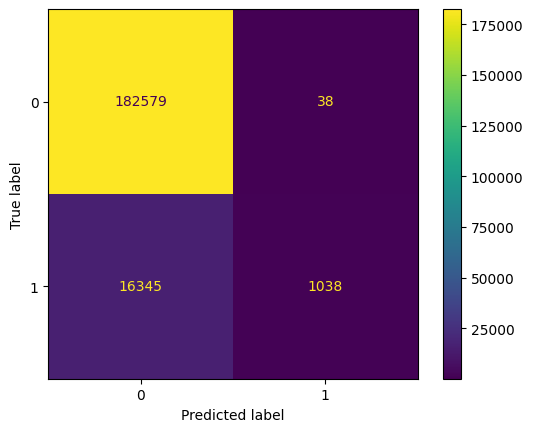

In [64]:
# Calculate some matrix and plot with confusion matrix for accuracy

y_test_arr = y_test.squeeze()
correct = np.equal(y_pred, y_test_arr).sum().item()
acc = (correct / len(y_pred)) * 100
precision = precision_score(y_test_arr, np.round(y_pred))
recall = recall_score(y_test_arr, np.round(y_pred))

print(f"Eval Metrics: \n Accuracy: {acc:>0.1f}%, "
      f"Precision: {precision:.4f}, Recall: {recall:.4f} \n")

c_matrix = confusion_matrix(y_test_arr, y_pred)
ConfusionMatrixDisplay(c_matrix).plot()


In [65]:
# Now let's pass a transaction to the model to see if this transaction is fraudulent or not

#Here is the order of the fields from Shahtab's transaction details:
#[distance_from_last_transaction,
#  ratio_to_median_price,
#. used_chip,
#. used_pin_number,
#. online_order]

shahtab_creditcard_transaction = [
    [0.3111400080477545,
    1.9459399775518593,
    1.0,
    0.0,
    0.0]
    ]


In [66]:
# shahtab_creditcard_transaction has been defined above

prediction = sess.run(
                      [output_name],
                      {input_name: scaler.transform(shahtab_creditcard_transaction).astype(np.float32)}
                     )

print("Is this transaction predicted to be fraudulent? (true = YES, false = NO) ")
print(np.squeeze(prediction) > threshold)

print("How likely is the transaction to be fraudulent? ")
print("{:.5f}".format(100 * np.squeeze(prediction)) + "%")


Is this transaction predicted to be fraudulent? (true = YES, false = NO) 
False
How likely is the transaction to be fraudulent? 
-7196.70508%
